In [84]:
# Generating some simple photon count data
import numpy as np
from scipy import stats
np.random.seed(1)  # for repeatability

F_true = 1000                     # true flux, say number of photons measured in 1 second
N = 50                        # number of measurements
F = stats.chi2(F_true).rvs(N)      # N measurements of the flux
e = np.sqrt(F)                    # errors on Poisson counts estimated via square root

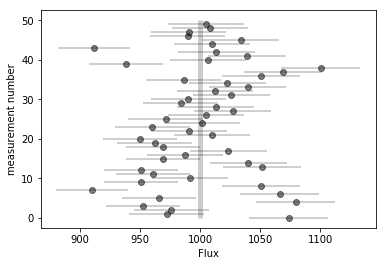

In [85]:
# show the results
fig, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("Flux");ax.set_ylabel("measurement number");
plt.show()

In [105]:
# estimate the f value
estimated_f = (e**2 * F).sum() / (e**2).sum()
print('Ground Truth f : ', F_true)
print('Estimated f    : ', estimated_f)
print("Error Bound +/-: ",  (1./e**2).sum() ** -0.5)

Ground Truth f :  1000
Estimated f    :  1002.8654341692877
Error Bound +/-:  4.470687512531004


In [106]:
# define some method for sampling
def log_posterior (theta, F, e): return log_prior(theta) + log_likelihood(theta, F, e)
def log_likelihood(theta, F, e): return -0.5 * np.sum(np.log(2 * np.pi * e ** 2) + (F - theta[0]) ** 2 / e ** 2)
def log_prior(theta):            return 1  # flat prior

In [107]:
# MCMC sampling
ndim      = 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn  = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations between 0 and 2000
starting_guesses = 2000 * np.random.rand(nwalkers, ndim)

import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].ravel()  # discard burn-in points

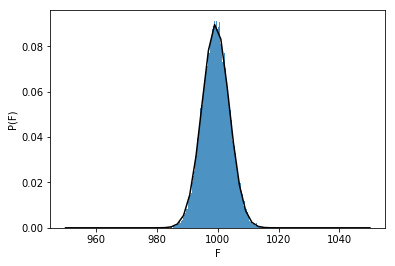

In [108]:
# plot a histogram of the sample
plt.hist(sample,bins='auto', alpha=0.8, density=True)

# plot a best-fit Gaussian
F_fit = np.linspace(950, 1050)
pdf   = stats.norm(np.mean(sample), np.std(sample)).pdf(F_fit)
plt.plot(F_fit, pdf, '-k')
plt.xlabel("F"); plt.ylabel("P(F)")
plt.show()

In [109]:
# now show the mean and the std value of the sample
print('Ground Truth f : ', F_true)
print('Estimated f    : ', sample.mean())
print("Error Bound +/-: ", sample.std())

Ground Truth f :  1000
Estimated f    :  999.283917265467
Error Bound +/-:  4.441323554281812


## Higher Dimension

In [112]:
# generate high
N = 100  # we'll use more samples for the more complicated model
mu_true, sigma_true = 1000, 15  # stochastic flux model

F_true = stats.norm(mu_true, sigma_true).rvs(N)  # (unknown) true flux
F      = stats.poisson(F_true).rvs()  # observed flux: true flux plus Poisson errors.
e      = np.sqrt(F)  # root-N error, as above

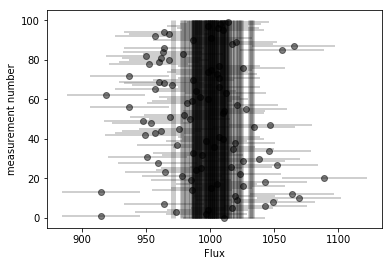

In [148]:
# show the results
fig, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("Flux");ax.set_ylabel("measurement number");
plt.show()

In [159]:
def log_likelihood(theta, F, e): return -0.5 * np.sum(np.log(2 * np.pi * (theta[1] ** 2 + e ** 2)) + (F - theta[0]) ** 2 / (theta[1] ** 2 + e ** 2))
# maximize likelihood <--> minimize negative likelihood
def neg_log_likelihood(theta, F, e): return -log_likelihood(theta, F, e)

from scipy import optimize
theta_guess = [0.2, 0.1]
theta_est   = optimize.fmin(neg_log_likelihood, theta_guess, args=(F, e))
print('Ground Truth Mean: ', mu_true)
print('Ground Truth STD : ', sigma_true)
print('Estimated Truth Mean: ', theta_est[0])
print('Estimated Truth STD : ', theta_est[1])

Optimization terminated successfully.
         Current function value: 495.816776
         Iterations: 101
         Function evaluations: 198
Ground Truth Mean:  1000
Ground Truth STD :  15
Estimated Truth Mean:  993.7490742048784
Estimated Truth STD :  13.811016708951232


In [160]:
def log_prior(theta):
    # sigma needs to be positive.
    if theta[1] <= 0:
        return -np.inf
    else:
        return 0
def log_posterior(theta, F, e): return log_prior(theta) + log_likelihood(theta, F, e)

# same setup as above:
ndim, nwalkers = 2, 50
nsteps, nburn = 2000, 1000

starting_guesses = np.random.rand(nwalkers, ndim)
starting_guesses[:, 0] *= 2000  # start mu between 0 and 2000
starting_guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)

In [166]:
print('Ground Truth Mean: ', mu_true)
print('Ground Truth STD : ', sigma_true)
print('Estimated Truth Mean: ', sample[:,0].mean())
print('Estimated Truth STD : ', sample[:,1].mean())

Ground Truth Mean:  1000
Ground Truth STD :  15
Estimated Truth Mean:  993.8414047022259
Estimated Truth STD :  12.932638947374839


In [169]:
from astroML.plotting import plot_mcmc
fig = plt.figure((10,10))
ax = plot_mcmc(sample.T, fig=fig, labels=[r'$\mu$', r'$\sigma$'], colors='k')
ax[0].plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
ax[0].plot([mu_true], [sigma_true], 'o', color='red', ms=10);
plt.show()

TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

# Reference
1. scipy.stats.chi2 — SciPy v1.1.0 Reference Guide. (2018). Docs.scipy.org. Retrieved 13 November 2018, from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html#scipy.stats.chi2
2. 